Сначала импортируем модуль thinkdsp.py.

In [81]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from thinkdsp import decorate
from thinkdsp import UncorrelatedGaussianNoise
from scipy.stats import linregress
from thinkdsp import read_wave

PI2 = np.pi * 2

## УПРАЖНЕНИЕ 6.1

В данном упражнении необходимо убедиться, что analyze1 требует времени пропорционально n$^{3}$, а  analyze2 - пропорционально n$^{2}$.

Создадим гауссов шум:

In [27]:
signal = UncorrelatedGaussianNoise()
wave = signal.make_wave(duration=1.0, framerate=16384)

С помощью следующей функции мы можем отобразить результаты временного эксперимента в виде линии.

In [28]:
def plot_bests(ns, bests):    
    plt.plot(ns, bests)
    loglog = dict(xscale='log', yscale='log')
    decorate(**loglog)
    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]
    return slope

Функция analyze1:

In [29]:
def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

Функция analyze2:

In [30]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

Для вычисления реультатов будет использоваться следующая функция:

In [31]:
def test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = wave.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)     
    bests = [result.best for result in results]
    return bests

Результаты для analyze1:

64
108 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
319 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
1.47 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
512
8.43 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
43 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
283 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
984 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.282765501472816

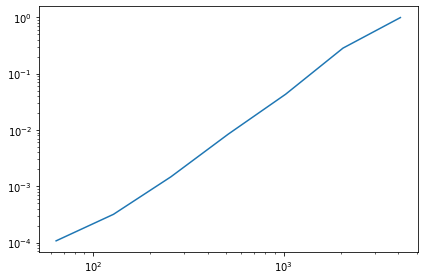

In [32]:
ns = 2 ** np.arange(6, 13)
bests = test(ns, analyze1)
plot_bests(ns, bests)

Полученный результат для analyze1 оказался ближе к 2, чем к 3 (возможно, из-за производительности np.linalg.solve) .

Результаты для analyze2:

64
57.5 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
229 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
1.27 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
512
6.97 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
27.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
84.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
308 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.09484654118537

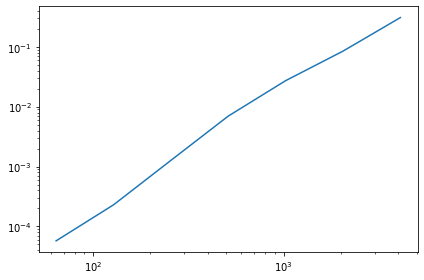

In [33]:
bests2 = test(ns, analyze2)
plot_bests(ns, bests2)

Полученный результат приблизительно равен 2, это ожидаемый результат.

В целом, полученные результаты близки к ожидаемым.

## УПРАЖНЕНИЕ 6.2

В данном упражнеии необходимо реализовать следующий предложенный алгоритм:
    1) Разбить длинный сигнал на сегменты;
    2) Вычислить ДКП каждого сегмента;
    3) Определить частотные компоненты с такой амплитудой, что их не слышно и удалить их, сохранив остальные;
    4) При воспроизведении загрузить частоты и амплитуды каждого сегмента и применить обратное ДКП.

Для выполнения упраженения используем один из предложенных в репозитории книги звуков - 92002__jcveliz__violin-origional.wav .

In [58]:
wave = read_wave('92002__jcveliz__violin-origional.wav')
segment = wave.segment(duration=1)
segment.normalize()
segment.make_audio()

Вычислим ДКП сегмента:

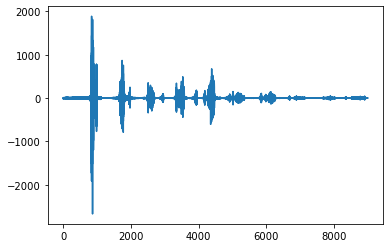

In [59]:
dct = segment.make_dct()
dct.plot(9000)

Используем функцию, обнуляющую элементы, которые ниже указанного порога:

In [60]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1
    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

Применим функцию к сегменту:

36875	44100	83.61678004535148


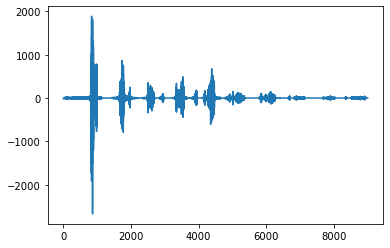

In [79]:
dct = segment.make_dct()
compress(dct, thresh=10)
dct.plot(high=9000)

In [80]:
seg1 = dct.make_wave()
seg1.make_audio()

При пороге = 10 звучание практически неотличимо от оригинала.

Уже при пороге в 30 слышны некоторые искажения звука, при пороге в 50 звучание становится менее качественным, слышно "шипение".